In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
def make_hello(N=1000, rseed=42):
    # Создаем рисунок с текстом "HELLO"; сохраняем его в формате PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold',
            size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    # Открываем этот PNG-файл и берем из него случайные точки
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

(-0.19972965643412033,
 4.195346643588747,
 0.019424089027564297,
 1.00023375581081)

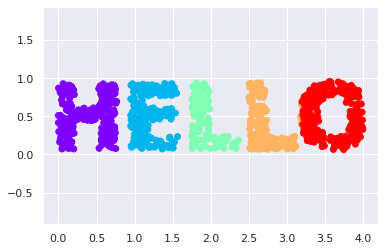

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

# MDS

Основная идея состоит в том, что при оценке зависимостей в данных исходные оси X, Y не так важны в представлении данных. К примеру если мы перевернем надпись HELLO диагонально, оси изменятся, но сама натпись останется такой же, хоть и в перевернутом виде. Это значит что большее значение имеют расстояния между каждой точкой. К примеру если мы выведем матрицу расстояний между точками для обычной надписи HELLO и для перевернутой, мы увидим, что хоть изображения разные, матрицы расстояния у них одинаковые.

(4.5075861286085335, 8.843422456688193, 4.979887550043001, 7.269825545795252)

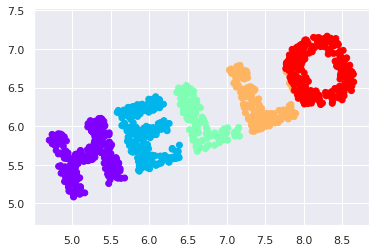

In [4]:
def rotate(X, angle):

    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)


X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal')

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

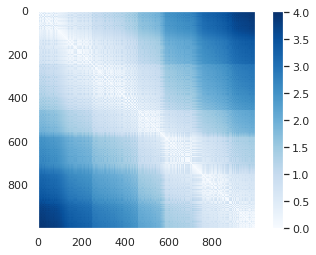

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

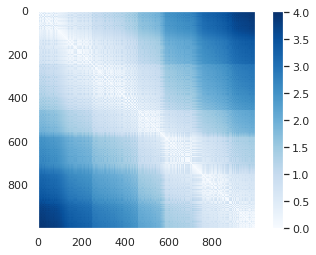

In [9]:
plt.imshow(D2, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

(-2.107894119080612,
 2.1463295776370446,
 -1.2702963324585892,
 1.2918301788213085)

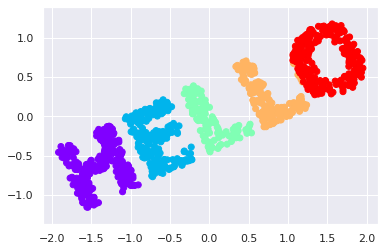

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed',
            random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

Как мы можем увидеть, MDS может восстановить одну из вариаций исходного изображения принимая на вход лишь матрицу расстояния между точками

# MDS manifold learning

In [10]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])


X3 = random_projection(X, 3)
X3.shape

(1000, 3)

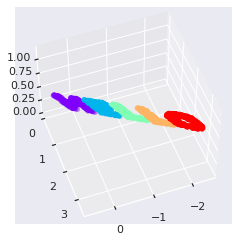

In [11]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

(-2.1078941190806133,
 2.1463295776370432,
 -1.2702963324585932,
 1.2918301788213098)

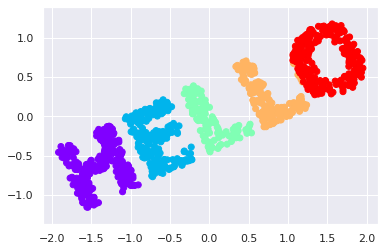

In [12]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

Как мы можем увидеть, если у нас есть трехмерное представление наших исходных значений, MDS вернет двумерную проекцию со всеми исходными зависимостями

# Non Linear Embeddings

In [13]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T


XS = make_hello_s_curve(X)

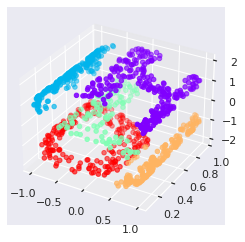

In [14]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize)

(-1.4671076909194074,
 1.4959420779420367,
 -2.3098516222530203,
 2.147946088353613)

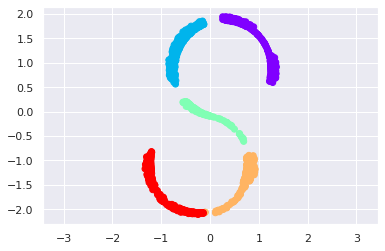

In [15]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

(0.15, -0.15)

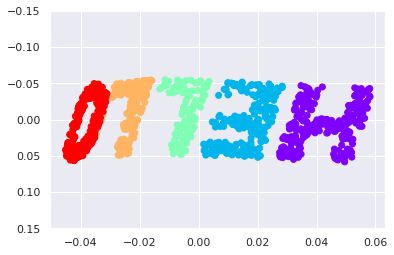

In [16]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2,
                               method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)

# Isomap for Face Recognition

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

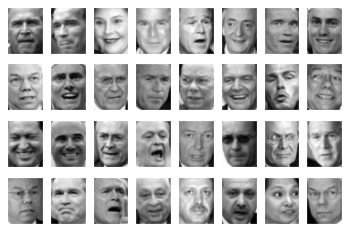

In [18]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

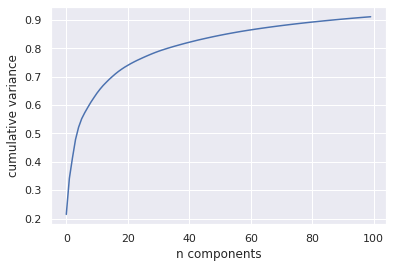

In [19]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
# Количество компонент
plt.ylabel('cumulative variance')  # Интегральная дисперсия

In [20]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [22]:
from matplotlib import offsetbox


def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) -
                                       proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # Не отображаем слишком близко расположенные точки
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                proj[i])
            ax.add_artist(imagebox)

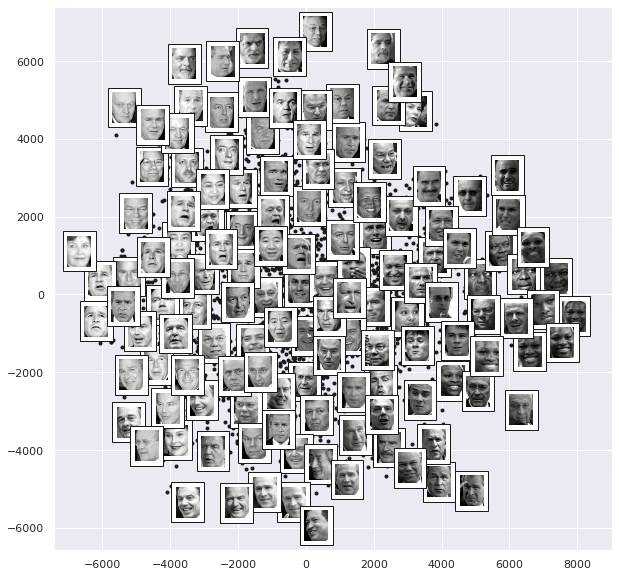

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

# Digits visualization

In [38]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y=y.astype(int)
X.shape

(70000, 784)

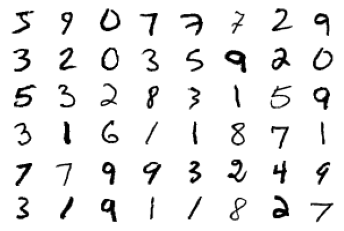

In [39]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(X[1250 * i].reshape(28, 28), cmap='gray_r')

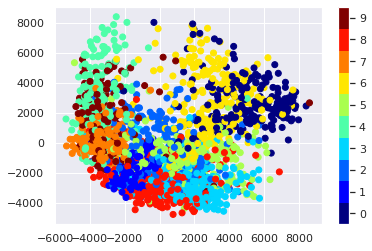

In [40]:
# используем только 1/30 часть данных:
# вычисления для полного набора данных занимают длительное время!
data = X[::30]
target = y[::30]
model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

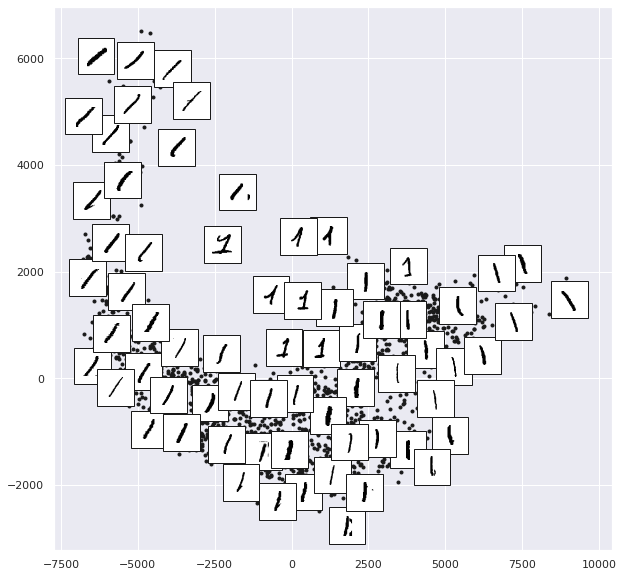

In [41]:
from sklearn.manifold import Isomap
# Выбираем для проекции 1/4 цифр "1"
data = X[y == 1][::4]
fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')